## Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [3]:
import hw

## Load data

In [4]:
cropped_data_dir = 'data/CroppedYale/'
cropped = hw.LoadCropped(cropped_data_dir)

In [5]:
gender_labels = np.array(['male', 'male','male','male','female','male','male','male',
                 'male','male','male','male','male','female','male','male',
                 'male','male','male','male','female','male','male','male',
                 'male','female','female','male','male','male','female','male',
                 'female','male','male','female','male','male'])
faces_dict = dict(zip(cropped.target_names, cropped.faces))
for i,v in enumerate(faces_dict):
    faces_dict[v] = [faces_dict[v],gender_labels[i]]
    
female_indices = []
females = []
males = []
male_indices = []
for key, value in faces_dict.items():
    if value[1] == 'male':
        males.append(value[0])
        for i in value[0].T:
            male_indices.append(0)
            
    else:
        females.append(value[0])
        for i in value[0].T:
            female_indices.append(1)
            
females = np.hstack(females).T
males = np.hstack(males).T

In [6]:
h             = cropped.h
w             = cropped.w
X             = np.vstack([males,females])
y             = np.hstack([male_indices, female_indices])
target_names  = np.array(['males','female'])
n_samples     = cropped.n_samples
n_features    = cropped.n_features
n_classes     = 2

## Split into training and test data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=42)

## Compute rank r truncation

In [8]:
U,S,VT = np.linalg.svd(X_train.T,full_matrices=0) 

In [9]:
var_explained = np.round(S**2/np.sum(S**2), decimals=100)
thresh = 0.99
cdf=np.cumsum(var_explained)
n_components = np.where(cdf>thresh)[0][0]
n_components

135

## Compute eigenfaces and project images into subspace

In [10]:
pca = PCA(n_components=n_components, 
          svd_solver='randomized',
          whiten=True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

## Model Comparison

### Support Vector Classification with Radial Basis Function

In [11]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

model = SVC(kernel='rbf', class_weight='balanced')

In [12]:
clf_svm_rbf = GridSearchCV(model, param_grid)
clf_svm_rbf = clf_svm_rbf.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf_svm_rbf.best_estimator_)
print("Score: %0.2f" % clf_svm_rbf.best_score_)

Best estimator found by grid search:
SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.0005,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Score: 0.96


In [13]:
df = pd.DataFrame(clf_svm_rbf.cv_results_)
df[df['mean_test_score'] == df['mean_test_score'].max()].iloc[0]

mean_fit_time                             0.0803592
std_fit_time                             0.00230279
mean_score_time                           0.0111182
std_score_time                          0.000361507
param_C                                        1000
param_gamma                                  0.0005
params               {'C': 1000.0, 'gamma': 0.0005}
split0_test_score                          0.977901
split1_test_score                          0.941989
split2_test_score                          0.950276
split3_test_score                          0.966851
split4_test_score                          0.958564
mean_test_score                            0.959116
std_test_score                            0.0125257
rank_test_score                                   1
Name: 1, dtype: object

In [14]:
y_pred_svm_rbf  = clf_svm_rbf.predict(X_test_pca)
print(classification_report(y_test, y_pred_svm_rbf, target_names=target_names))

              precision    recall  f1-score   support

       males       0.97      0.98      0.97       489
      female       0.90      0.88      0.89       115

    accuracy                           0.96       604
   macro avg       0.94      0.93      0.93       604
weighted avg       0.96      0.96      0.96       604



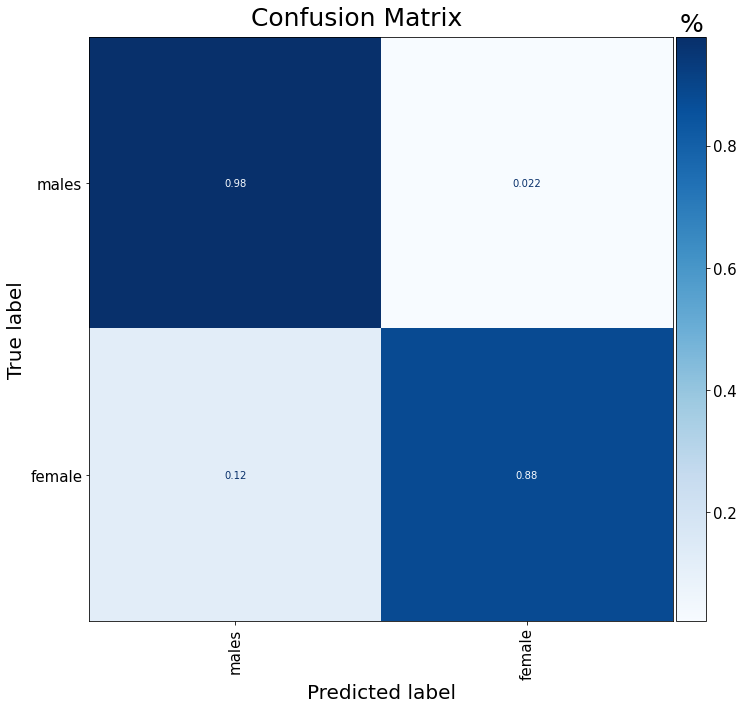

In [15]:
clf = clf_svm_rbf
fig,ax = plt.subplots(figsize=(10,10))
im = plot_confusion_matrix(clf, X_test_pca, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true', ax=ax)

im.im_.colorbar.remove()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
clb = plt.colorbar(im.im_, cax=cax)
clb.ax.set_title('%', fontsize=25)
clb.ax.tick_params(axis='y', labelsize=15)

ax.tick_params(axis='x', labelrotation=90, labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
fig.suptitle('Confusion Matrix', fontsize=25)

plt.tight_layout()
plt.subplots_adjust(top=1.02)

### Support Vector Classification with Linear Decision Boundaries

In [16]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

model = SVC(kernel='linear', class_weight='balanced')

In [17]:
clf_svm_ln = GridSearchCV(model, param_grid)
clf_svm_ln = clf_svm_ln.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf_svm_ln.best_estimator_)
print("Score: %0.2f" % clf_svm_ln.best_score_)

Best estimator found by grid search:
SVC(C=5000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.0001,
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Score: 0.93


In [18]:
df = pd.DataFrame(clf_svm_ln.cv_results_)
df[df['mean_test_score'] == df['mean_test_score'].max()].iloc[0]

mean_fit_time                              0.124218
std_fit_time                              0.0394801
mean_score_time                          0.00506315
std_score_time                           0.00020199
param_C                                        5000
param_gamma                                  0.0001
params               {'C': 5000.0, 'gamma': 0.0001}
split0_test_score                          0.947514
split1_test_score                          0.928177
split2_test_score                           0.91989
split3_test_score                          0.936464
split4_test_score                          0.928177
mean_test_score                            0.932044
std_test_score                           0.00934339
rank_test_score                                   1
Name: 6, dtype: object

In [19]:
y_pred_svm_ln  = clf_svm_ln.predict(X_test_pca)
print(classification_report(y_test, y_pred_svm_ln, target_names=target_names))

              precision    recall  f1-score   support

       males       0.96      0.96      0.96       489
      female       0.82      0.82      0.82       115

    accuracy                           0.93       604
   macro avg       0.89      0.89      0.89       604
weighted avg       0.93      0.93      0.93       604



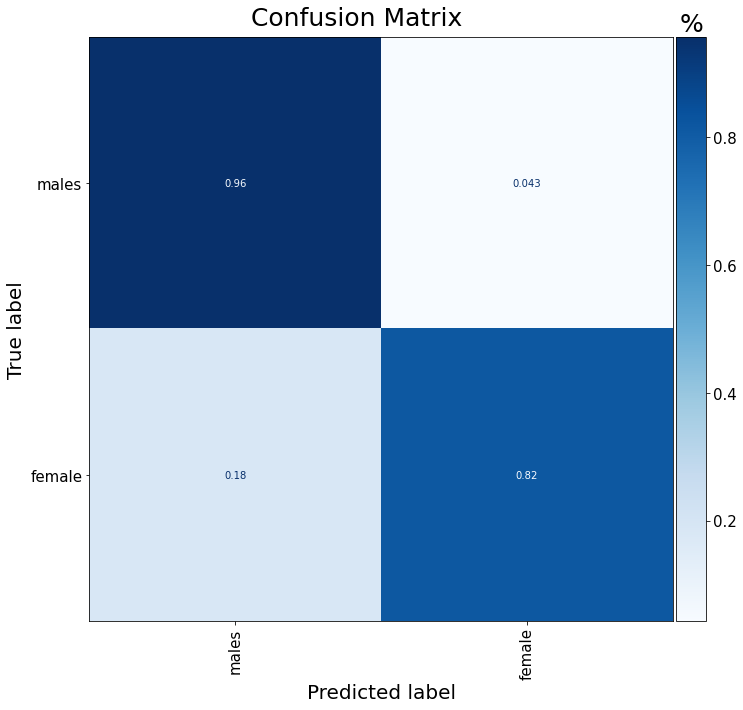

In [20]:
clf = clf_svm_ln
fig,ax = plt.subplots(figsize=(10,10))
im = plot_confusion_matrix(clf, X_test_pca, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true', ax=ax)

im.im_.colorbar.remove()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
clb = plt.colorbar(im.im_, cax=cax)
clb.ax.set_title('%', fontsize=25)
clb.ax.tick_params(axis='y', labelsize=15)

ax.tick_params(axis='x', labelrotation=90, labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
fig.suptitle('Confusion Matrix', fontsize=25)

plt.tight_layout()
plt.subplots_adjust(top=1.02)

### Gaussian Naive Bayes

In [21]:
param_grid = {'var_smoothing': [1e-10, 1e-09, 1e-08], }

model = GaussianNB()

In [22]:
clf_gnb = GridSearchCV(model, param_grid)
clf_gnb = clf_gnb.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf_gnb.best_estimator_)
print("Score: %0.2f" % clf_gnb.best_score_)

Best estimator found by grid search:
GaussianNB(priors=None, var_smoothing=1e-10)
Score: 0.91


In [23]:
df = pd.DataFrame(clf_gnb.cv_results_)
df[df['mean_test_score'] == df['mean_test_score'].max()].iloc[0]

mean_fit_time                        0.00207453
std_fit_time                        0.000382875
mean_score_time                     0.000972795
std_score_time                      0.000240923
param_var_smoothing                       1e-10
params                 {'var_smoothing': 1e-10}
split0_test_score                      0.922652
split1_test_score                      0.881215
split2_test_score                      0.933702
split3_test_score                      0.906077
split4_test_score                      0.892265
mean_test_score                        0.907182
std_test_score                        0.0191865
rank_test_score                               1
Name: 0, dtype: object

In [24]:
y_pred_gnb  = clf_gnb.predict(X_test_pca)
print(classification_report(y_test, y_pred_gnb, target_names=target_names))

              precision    recall  f1-score   support

       males       0.93      0.98      0.96       489
      female       0.90      0.69      0.78       115

    accuracy                           0.93       604
   macro avg       0.91      0.83      0.87       604
weighted avg       0.92      0.93      0.92       604



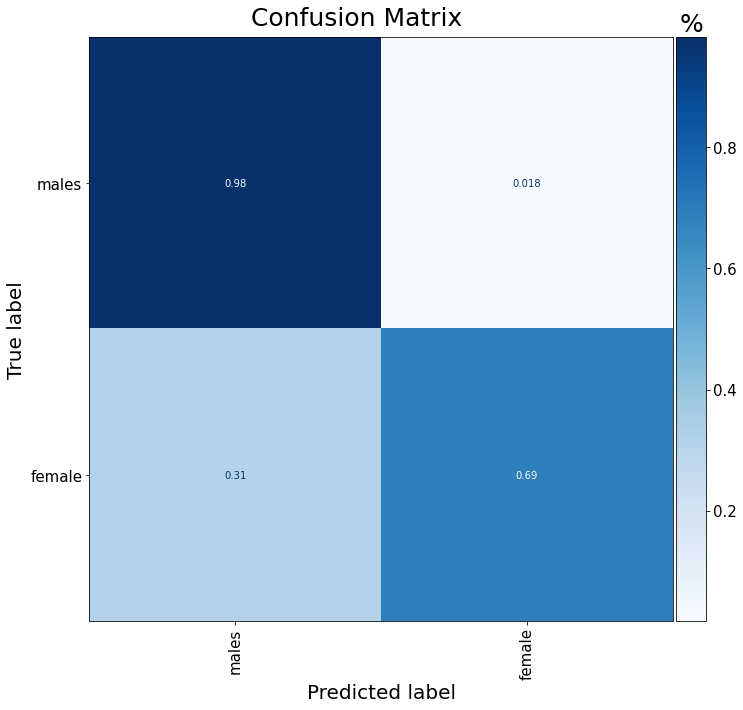

In [25]:
clf = clf_gnb
fig,ax = plt.subplots(figsize=(10,10))
im = plot_confusion_matrix(clf, X_test_pca, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true', ax=ax)

im.im_.colorbar.remove()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
clb = plt.colorbar(im.im_, cax=cax)
clb.ax.set_title('%', fontsize=25)
clb.ax.tick_params(axis='y', labelsize=15)

ax.tick_params(axis='x', labelrotation=90, labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
fig.suptitle('Confusion Matrix', fontsize=25)

plt.tight_layout()
plt.subplots_adjust(top=1.02)

### K-Nearest Neighbors

In [26]:
param_grid = {'weights': ['uniform', 'distance'],
              'n_neighbors': [1, 2, 3, 5, 10, 50], }

model = KNeighborsClassifier(n_jobs=-1)

In [57]:
%%time
clf_knn = GridSearchCV(model, param_grid)
clf_knn = clf_knn.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf_knn.best_estimator_)
print("Score: %0.2f" % clf_knn.best_score_)

Best estimator found by grid search:
QuadraticDiscriminantAnalysis(priors=None, reg_param=0.001,
                              store_covariance=False, tol=0.0001)
Score: 0.97
CPU times: user 19.2 s, sys: 735 ms, total: 19.9 s
Wall time: 2.6 s


In [28]:
df = pd.DataFrame(clf_knn.cv_results_)
df[df['mean_test_score'] == df['mean_test_score'].max()].iloc[0]

mean_fit_time                                      0.00573826
std_fit_time                                      0.000417749
mean_score_time                                     0.0724537
std_score_time                                     0.00870619
param_n_neighbors                                           2
param_weights                                         uniform
params               {'n_neighbors': 2, 'weights': 'uniform'}
split0_test_score                                    0.975138
split1_test_score                                    0.966851
split2_test_score                                    0.975138
split3_test_score                                    0.961326
split4_test_score                                    0.983425
mean_test_score                                      0.972376
std_test_score                                      0.0076155
rank_test_score                                             1
Name: 2, dtype: object

In [29]:
y_pred_knn  = clf_knn.predict(X_test_pca)
print(classification_report(y_test, y_pred_knn, target_names=target_names))

              precision    recall  f1-score   support

       males       0.97      0.99      0.98       489
      female       0.97      0.85      0.91       115

    accuracy                           0.97       604
   macro avg       0.97      0.92      0.94       604
weighted avg       0.97      0.97      0.97       604



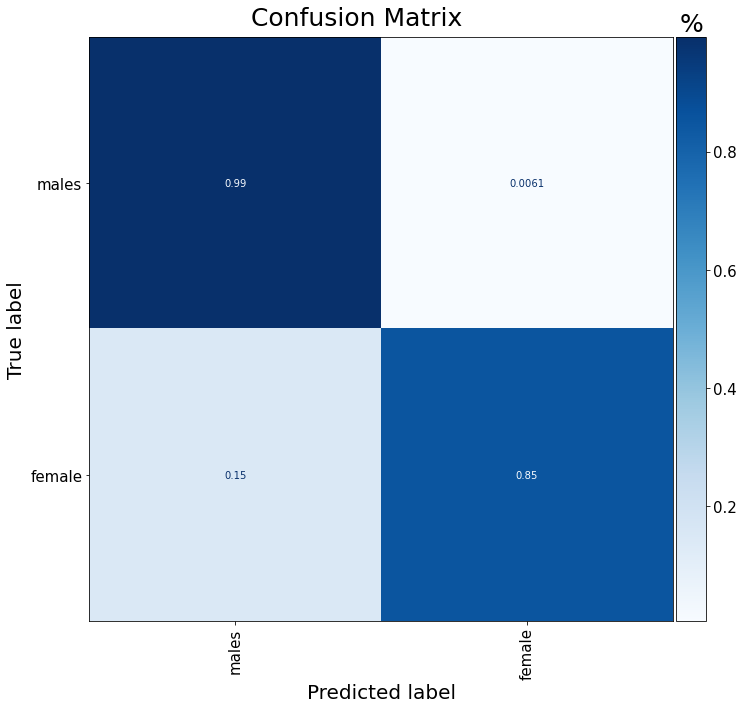

In [30]:
clf = clf_knn
fig,ax = plt.subplots(figsize=(10,10))
im = plot_confusion_matrix(clf, X_test_pca, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true', ax=ax)

im.im_.colorbar.remove()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
clb = plt.colorbar(im.im_, cax=cax)
clb.ax.set_title('%', fontsize=25)
clb.ax.tick_params(axis='y', labelsize=15)

ax.tick_params(axis='x', labelrotation=90, labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
fig.suptitle('Confusion Matrix', fontsize=25)

plt.tight_layout()
plt.subplots_adjust(top=1.02)

### Decision Tree

In [31]:
param_grid = {'max_depth': [None, 50, 100, 150, 200, 1000],
              'criterion': ['gini', 'entropy']}

model = DecisionTreeClassifier()

In [32]:
clf_dtc = GridSearchCV(model, param_grid)
clf_dtc = clf_dtc.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf_dtc.best_estimator_)
print("Score: %0.2f" % clf_dtc.best_score_)

Best estimator found by grid search:
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=200, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Score: 0.87


In [33]:
df = pd.DataFrame(clf_dtc.cv_results_)
df[df['mean_test_score'] == df['mean_test_score'].max()].iloc[0]

mean_fit_time                                          0.169848
std_fit_time                                         0.00976835
mean_score_time                                     0.000575781
std_score_time                                      1.95276e-05
param_criterion                                         entropy
param_max_depth                                             200
params               {'criterion': 'entropy', 'max_depth': 200}
split0_test_score                                      0.889503
split1_test_score                                      0.823204
split2_test_score                                      0.895028
split3_test_score                                      0.883978
split4_test_score                                      0.875691
mean_test_score                                        0.873481
std_test_score                                        0.0259374
rank_test_score                                               1
Name: 10, dtype: object

In [34]:
y_pred_dtc  = clf_dtc.predict(X_test_pca)
print(classification_report(y_test, y_pred_dtc, target_names=target_names))

              precision    recall  f1-score   support

       males       0.92      0.92      0.92       489
      female       0.66      0.67      0.66       115

    accuracy                           0.87       604
   macro avg       0.79      0.79      0.79       604
weighted avg       0.87      0.87      0.87       604



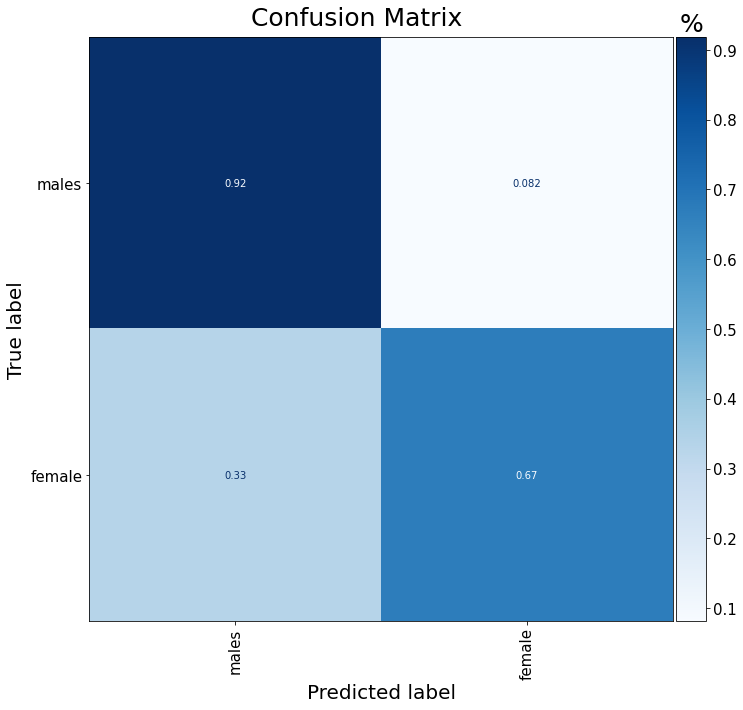

In [35]:
clf = clf_dtc
fig,ax = plt.subplots(figsize=(10,10))
im = plot_confusion_matrix(clf, X_test_pca, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true', ax=ax)

im.im_.colorbar.remove()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
clb = plt.colorbar(im.im_, cax=cax)
clb.ax.set_title('%', fontsize=25)
clb.ax.tick_params(axis='y', labelsize=15)

ax.tick_params(axis='x', labelrotation=90, labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
fig.suptitle('Confusion Matrix', fontsize=25)

plt.tight_layout()
plt.subplots_adjust(top=1.02)

### Random Forest 

In [36]:
param_grid = {'max_depth': [None, 50, 100, 150, 200, 1000],
              'n_estimators': [1, 5, 10, 50, 100, 200],
              'criterion': ['gini', 'entropy']}

model = RandomForestClassifier(n_jobs=-1)

In [37]:
clf_rfc = GridSearchCV(model, param_grid)
clf_rfc = clf_rfc.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf_rfc.best_estimator_)
print("Score: %0.2f" % clf_rfc.best_score_)

Best estimator found by grid search:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=200, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
Score: 0.92


In [38]:
df = pd.DataFrame(clf_rfc.cv_results_)
df[df['mean_test_score'] == df['mean_test_score'].max()].iloc[0]

mean_fit_time                                                   1.96192
std_fit_time                                                   0.282262
mean_score_time                                                0.111479
std_score_time                                                0.0105687
param_criterion                                                    gini
param_max_depth                                                     200
param_n_estimators                                                  200
params                {'criterion': 'gini', 'max_depth': 200, 'n_est...
split0_test_score                                              0.917127
split1_test_score                                               0.91989
split2_test_score                                              0.911602
split3_test_score                                              0.922652
split4_test_score                                              0.911602
mean_test_score                                                0

In [39]:
y_pred_rfc  = clf_dtc.predict(X_test_pca)
print(classification_report(y_test, y_pred_rfc, target_names=target_names))

              precision    recall  f1-score   support

       males       0.92      0.92      0.92       489
      female       0.66      0.67      0.66       115

    accuracy                           0.87       604
   macro avg       0.79      0.79      0.79       604
weighted avg       0.87      0.87      0.87       604



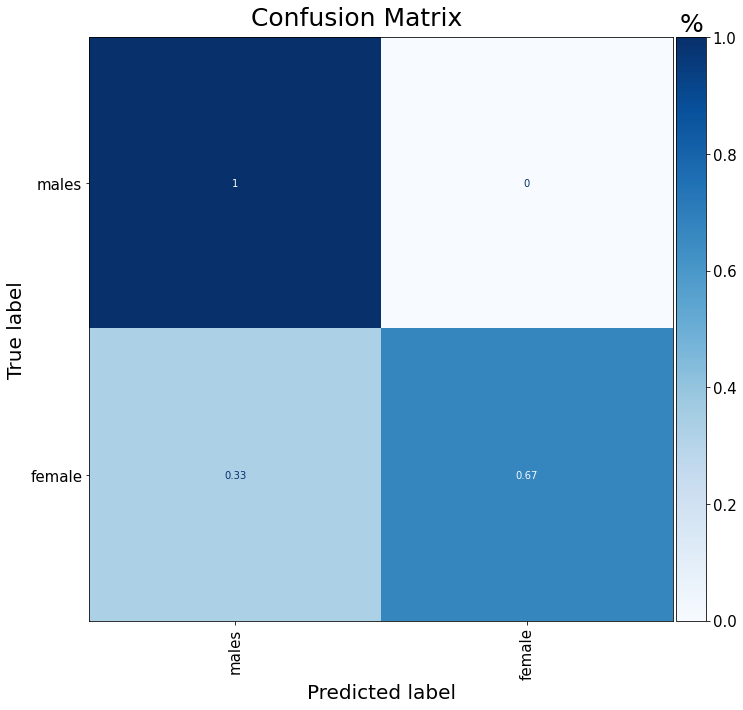

In [40]:
clf = clf_rfc
fig,ax = plt.subplots(figsize=(10,10))
im = plot_confusion_matrix(clf, X_test_pca, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true', ax=ax)

im.im_.colorbar.remove()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
clb = plt.colorbar(im.im_, cax=cax)
clb.ax.set_title('%', fontsize=25)
clb.ax.tick_params(axis='y', labelsize=15)

ax.tick_params(axis='x', labelrotation=90, labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
fig.suptitle('Confusion Matrix', fontsize=25)

plt.tight_layout()
plt.subplots_adjust(top=1.02)

### Adaboost

In [41]:
param_grid = {'n_estimators': [1, 5, 10, 50, 100, 200],
             'learning_rate': [0.001, 0.1, 1]}

model = AdaBoostClassifier()

In [42]:
clf_adab = GridSearchCV(model, param_grid)
clf_adab = clf_adab.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf_adab.best_estimator_)
print("Score: %0.2f" % clf_adab.best_score_)

Best estimator found by grid search:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=200, random_state=None)
Score: 0.94


In [43]:
df = pd.DataFrame(clf_adab.cv_results_)
df[df['mean_test_score'] == df['mean_test_score'].max()].iloc[0]

mean_fit_time                                            4.82709
std_fit_time                                             0.17944
mean_score_time                                        0.0552946
std_score_time                                        0.00262398
param_learning_rate                                            1
param_n_estimators                                           200
params                 {'learning_rate': 1, 'n_estimators': 200}
split0_test_score                                       0.939227
split1_test_score                                       0.941989
split2_test_score                                       0.922652
split3_test_score                                       0.944751
split4_test_score                                       0.944751
mean_test_score                                         0.938674
std_test_score                                        0.00826886
rank_test_score                                                1
Name: 17, dtype: object

In [44]:
y_pred_adab  = clf_adab.predict(X_test_pca)
print(classification_report(y_test, y_pred_adab, target_names=target_names))

              precision    recall  f1-score   support

       males       0.95      0.97      0.96       489
      female       0.86      0.77      0.81       115

    accuracy                           0.93       604
   macro avg       0.90      0.87      0.88       604
weighted avg       0.93      0.93      0.93       604



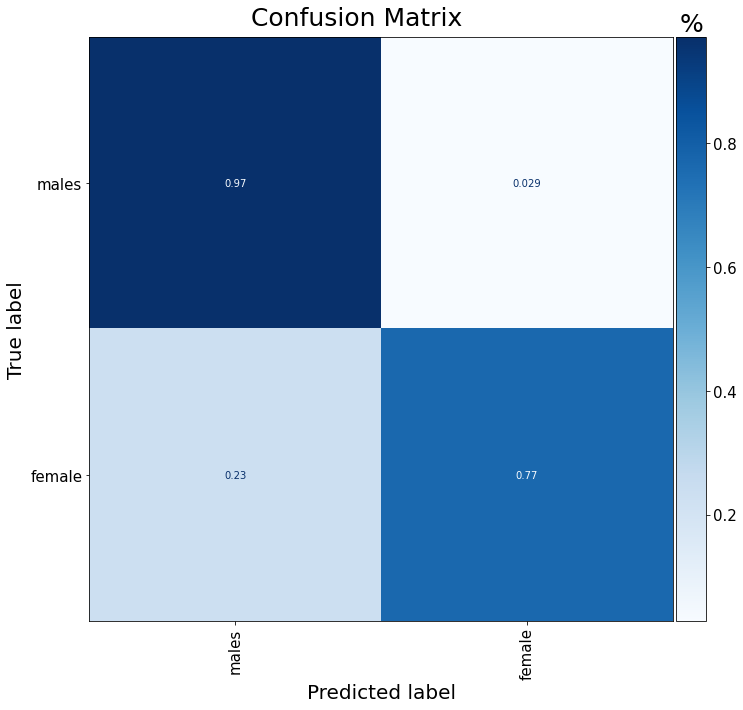

In [45]:
clf = clf_adab
fig,ax = plt.subplots(figsize=(10,10))
im = plot_confusion_matrix(clf, X_test_pca, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true', ax=ax)

im.im_.colorbar.remove()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
clb = plt.colorbar(im.im_, cax=cax)
clb.ax.set_title('%', fontsize=25)
clb.ax.tick_params(axis='y', labelsize=15)

ax.tick_params(axis='x', labelrotation=90, labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
fig.suptitle('Confusion Matrix', fontsize=25)

plt.tight_layout()
plt.subplots_adjust(top=1.02)

### Linear Discriminant Analysis

In [46]:
param_grid = {'tol': [0.0001, 0.001, 0.01, 0.1, 1]}

model = LinearDiscriminantAnalysis()

In [47]:
clf_lda = GridSearchCV(model, param_grid)
clf_lda = clf_lda.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf_lda.best_estimator_)
print("Score: %0.2f" % clf_lda.best_score_)

Best estimator found by grid search:
LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
Score: 0.95


In [48]:
df = pd.DataFrame(clf_lda.cv_results_)
df[df['mean_test_score'] == df['mean_test_score'].max()].iloc[0]

mean_fit_time               0.061649
std_fit_time              0.00881511
mean_score_time          0.000693893
std_score_time           8.54138e-06
param_tol                     0.0001
params               {'tol': 0.0001}
split0_test_score           0.950276
split1_test_score           0.950276
split2_test_score           0.961326
split3_test_score           0.947514
split4_test_score           0.950276
mean_test_score             0.951934
std_test_score            0.00481646
rank_test_score                    1
Name: 0, dtype: object

In [49]:
y_pred_lda  = clf_lda.predict(X_test_pca)
print(classification_report(y_test, y_pred_lda, target_names=target_names))

              precision    recall  f1-score   support

       males       0.95      0.99      0.97       489
      female       0.94      0.76      0.84       115

    accuracy                           0.94       604
   macro avg       0.94      0.87      0.90       604
weighted avg       0.94      0.94      0.94       604



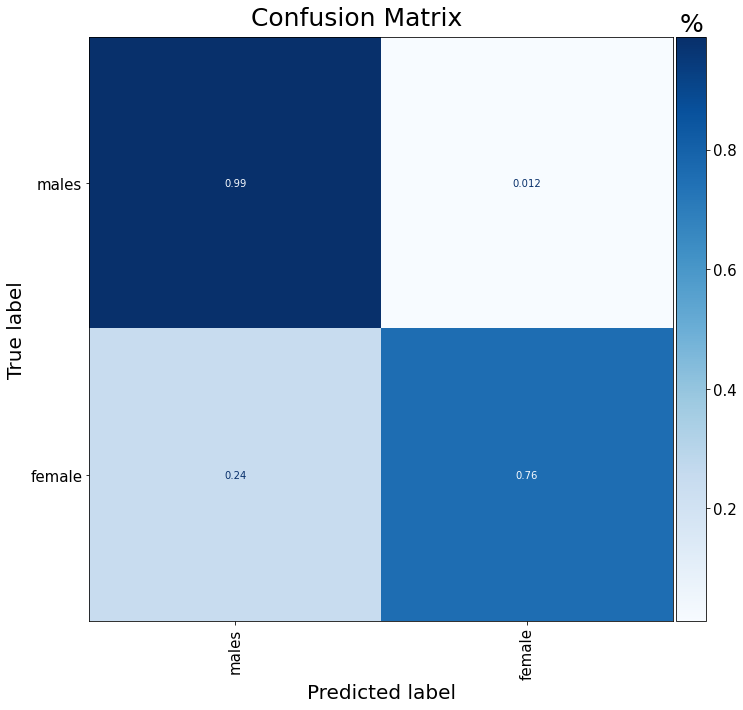

In [50]:
clf = clf_lda
fig,ax = plt.subplots(figsize=(10,10))
im = plot_confusion_matrix(clf, X_test_pca, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true', ax=ax)

im.im_.colorbar.remove()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
clb = plt.colorbar(im.im_, cax=cax)
clb.ax.set_title('%', fontsize=25)
clb.ax.tick_params(axis='y', labelsize=15)

ax.tick_params(axis='x', labelrotation=90, labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
fig.suptitle('Confusion Matrix', fontsize=25)

plt.tight_layout()
plt.subplots_adjust(top=1.02)

### Quadratic Discriminant Analysis

In [51]:
param_grid = {'tol': [0.0001, 0.001, 0.01, 0.1, 1],
              'reg_param': [1, 0.0, 0.001, 0.0001]}

model = QuadraticDiscriminantAnalysis()

In [56]:
%%time
clf_qda = GridSearchCV(model, param_grid)
clf_qda = clf_qda.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf_qda.best_estimator_)
print("Score: %0.2f" % clf_qda.best_score_)

Best estimator found by grid search:
QuadraticDiscriminantAnalysis(priors=None, reg_param=0.001,
                              store_covariance=False, tol=0.0001)
Score: 0.97
CPU times: user 22.6 s, sys: 2.43 s, total: 25.1 s
Wall time: 3.87 s


In [53]:
df = pd.DataFrame(clf_qda.cv_results_)
df[df['mean_test_score'] == df['mean_test_score'].max()].iloc[0]

mean_fit_time                                  0.0563837
std_fit_time                                   0.0045646
mean_score_time                               0.00309596
std_score_time                               0.000363653
param_reg_param                                    0.001
param_tol                                         0.0001
params               {'reg_param': 0.001, 'tol': 0.0001}
split0_test_score                               0.972376
split1_test_score                               0.953039
split2_test_score                               0.969613
split3_test_score                               0.964088
split4_test_score                               0.983425
mean_test_score                                 0.968508
std_test_score                                 0.0099754
rank_test_score                                        1
Name: 10, dtype: object

In [54]:
y_pred_qda  = clf_qda.predict(X_test_pca)
print(classification_report(y_test, y_pred_qda, target_names=target_names))

              precision    recall  f1-score   support

       males       0.98      0.99      0.99       489
      female       0.95      0.92      0.94       115

    accuracy                           0.98       604
   macro avg       0.97      0.96      0.96       604
weighted avg       0.98      0.98      0.98       604



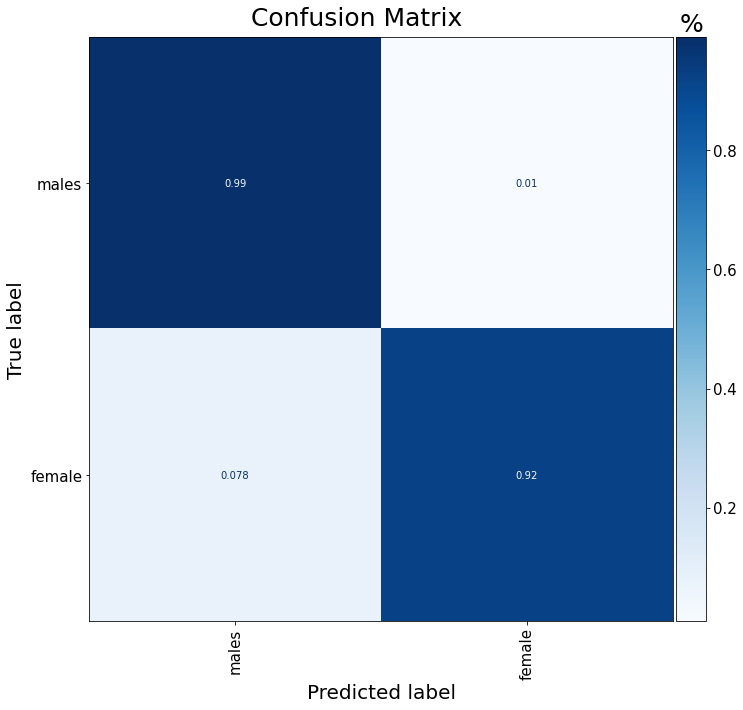

In [55]:
clf = clf_qda
fig,ax = plt.subplots(figsize=(10,10))
im = plot_confusion_matrix(clf, X_test_pca, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true', ax=ax)

im.im_.colorbar.remove()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
clb = plt.colorbar(im.im_, cax=cax)
clb.ax.set_title('%', fontsize=25)
clb.ax.tick_params(axis='y', labelsize=15)

ax.tick_params(axis='x', labelrotation=90, labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
fig.suptitle('Confusion Matrix', fontsize=25)

plt.tight_layout()
plt.subplots_adjust(top=1.02)

## References

https://scikit-learn.org/0.16/auto_examples/classification/plot_classifier_comparison.html  
https://www.youtube.com/watch?v=epoHE2rex0g&list=PLMrJAkhIeNNSVjnsviglFoY2nXildDCcv&index=36  
https://ieeexplore.ieee.org/document/6846297